In [581]:
import io, math
from scipy.io import arff
from sklearn.metrics import max_error
from sklearn.metrics import mean_squared_error
from datetime import datetime

import sklearn
import pandas as pd
import seaborn as sns
import numpy as np
import shap
import matplotlib.pyplot as plt
import plotly.express as px
import squarify as sq
import ast

# Project goal
 The project’s goal is to develop a machine learning model that predicts the IMDb ratings for unreleased movies. The aim is to figure out what common factors influence how movies are rated on IMDb, by studying trends from past movies. This includes variables such as genre, director, cast, budget, marketing intensity, historical trends. The machine learning model will be trained on a dataset that includes these factors from previous movies, as well as their relevance to IMDb ratings.


# Data provisioning

### Loading the dataset

Grijalva, D. (2020). Movie Industry. Kaggle. https://www.kaggle.com/datasets/danielgrijalvas/movies

In [582]:
df = pd.read_csv('movies.csv')
df

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7663,More to Life,NaN,Drama,2020,"October 23, 2020 (United States)",3.1,18.0,Joseph Ebanks,Joseph Ebanks,Shannon Bond,United States,7000.0,NaN,NaN,90.0
7664,Dream Round,NaN,Comedy,2020,"February 7, 2020 (United States)",4.7,36.0,Dusty Dukatz,Lisa Huston,Michael Saquella,United States,NaN,NaN,Cactus Blue Entertainment,90.0
7665,Saving Mbango,NaN,Drama,2020,"April 27, 2020 (Cameroon)",5.7,29.0,Nkanya Nkwai,Lynno Lovert,Onyama Laura,United States,58750.0,NaN,Embi Productions,NaN
7666,It's Just Us,NaN,Drama,2020,"October 1, 2020 (United States)",NaN,NaN,James Randall,James Randall,Christina Roz,United States,15000.0,NaN,NaN,120.0


### Content 

There are 6820 movies in the dataset (220 movies per year, 1986-2016). Each movie has the following attributes:

name: name of the movie

rating: rating of the movie (R, PG, etc.)

genre: main genre of the movie.

budget: the budget of a movie. Some movies don't have this, so it appears as 0

company: the production company

country: country of origin

director: the director

gross: revenue of the movie

released: release date (YYYY-MM-DD)

runtime: duration of the movie

score: IMDb user rating

votes: number of user votes

star: main actor/actress

writer: writer of the movie


In [583]:
# Splitting the 'released' column into 'release_date', 'release_country'
df[['release_date', 'release_country']] = df['released'].str.split(' \(', expand=True)
df['release_country'] = df['release_country'].str.replace(')', '')

# Removing the 'released' column
df.drop('released', axis=1, inplace=True)

# Displaying the modified dataset
df.head()

,name,rating,genre,year,score,votes,director,writer,star,country,budget,gross,company,runtime,release_date,release_country
0,The Shining,R,Drama,1980,8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0,"June 13, 1980",United States
1,The Blue Lagoon,R,Adventure,1980,5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0,"July 2, 1980",United States
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0,"June 20, 1980",United States
3,Airplane!,PG,Comedy,1980,7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0,"July 2, 1980",United States
4,Caddyshack,R,Comedy,1980,7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0,"July 25, 1980",United States


In [584]:
print(df['budget'].describe())


count    5.497000e+03
mean     3.558988e+07
std      4.145730e+07
min      3.000000e+03
25%      1.000000e+07
50%      2.050000e+07
75%      4.500000e+07
max      3.560000e+08
Name: budget, dtype: float64


Splitting release_date column onluy for a date

In [585]:
# Re-attempting the conversion of 'release_date' to only include month and day
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce').dt.strftime('%B %d')

# Check if the transformation has been successful
df[['release_date']].head()


,release_date
0,June 13
1,July 02
2,June 20
3,July 02
4,July 25


In [586]:
df.dtypes

name                object
rating              object
genre               object
year                 int64
score              float64
votes              float64
director            object
writer              object
star                object
country             object
budget             float64
gross              float64
company             object
runtime            float64
release_date        object
release_country     object
dtype: object

After checking datatypes they seem to be as I expected. 

In [587]:
from sklearn.preprocessing import LabelEncoder

encoded_df = df.copy()

# Initialize LabelEncoder
le = LabelEncoder()

# Specified categorical columns to encode
categorical_columns = ['name', 'rating', 'genre', 'director', 'writer', 'star', 'country', 'company', 'release_date', 'release_country']

# Apply label encoding to each categorical column in the DataFrame
for column in categorical_columns:
    encoded_df[column] = le.fit_transform(encoded_df[column].astype(str))  # Ensuring data type compatibility

# Handle missing values for numerical columns if there are any
numerical_columns = ['budget', 'gross', 'runtime', 'score', 'votes']
encoded_df[numerical_columns] = df[numerical_columns].fillna(encoded_df[numerical_columns].mean())

# Confirm changes and check for any remaining issues
encoded_df.head(), encoded_df.isnull().sum()

(   name  rating  genre  year  score      votes  director  writer  star  \
 0  6587       6      6  1980    8.4   927000.0      2589    4014  1047   
 1  5573       6      1  1980    5.8    65000.0      2269    1632   327   
 2  5142       4      0  1980    8.7  1200000.0      1111    2567  1745   
 3   286       4      4  1980    7.7   221000.0      1301    2000  2246   
 4  1027       6      4  1980    7.3   108000.0      1054     521   410   
 
    country      budget        gross  company  runtime  release_date  \
 0       54  19000000.0   46998772.0     2319    146.0           195   
 1       55   4500000.0   58853106.0      731    104.0           153   
 2       55  18000000.0  538375067.0     1540    124.0           202   
 3       55   3500000.0   83453539.0     1812     88.0           153   
 4       55   6000000.0   39846344.0     1777     98.0           176   
 
    release_country  
 0               56  
 1               56  
 2               56  
 3               56  
 4  

## Data description

We can see that the nean runtime of the movie is 107 minutes (1 hour 47 minutes), the average rating of movies is 6.3 and movies have significantly different budgets and gross earnings.

In [588]:
df.describe()

,year,score,votes,budget,gross,runtime
count,7668.000000,7665.000000,7.665000e+03,5.497000e+03,7.479000e+03,7664.000000
mean,2000.405451,6.390411,8.810850e+04,3.558988e+07,7.850054e+07,107.261613
std,11.153508,0.968842,1.633238e+05,4.145730e+07,1.657251e+08,18.581247
min,1980.000000,1.900000,7.000000e+00,3.000000e+03,3.090000e+02,55.000000
25%,1991.000000,5.800000,9.100000e+03,1.000000e+07,4.532056e+06,95.000000
50%,2000.000000,6.500000,3.300000e+04,2.050000e+07,2.020576e+07,104.000000
75%,2010.000000,7.100000,9.300000e+04,4.500000e+07,7.601669e+07,116.000000
max,2020.000000,9.300000,2.400000e+06,3.560000e+08,2.847246e+09,366.000000


## Handeling missing values

The dataset is <b>missing</b>: 2171 budget values, 189 gross values, 77 rating values, 3 score and votes values, 2 released values, 17 company values and 4 runtime values

In [589]:
missing_values = df.isnull().sum()

# Print the counts of missing values
print(missing_values)

name                  0
rating               77
genre                 0
year                  0
score                 3
votes                 3
director              0
writer                3
star                  1
country               3
budget             2171
gross               189
company              17
runtime               4
release_date         59
release_country       2
dtype: int64


## Why is the data missing? (MCAR, MNAR, MAR)

### Missing budget

The budget data is MAR, because there is not obvious trend why the data is missing, we can see certain period of data missingness

The data shows a higher frequency of missing values in the late 1980s and early 1990s. This could suggest changes in data collection methods, industry standards, or even the economic landscape affecting film production and reporting.

There is a noticeable presence of missing values in recent years (2017, 2018, 2019). Possible issues might be related to digital data collection methods.

In [590]:
missing_budget_by_year = df.groupby('year')['budget'].apply(lambda x: x.isnull().sum())
# Sorting the values to find years with the highest amount of missing budget data
missing_budget_by_year_sorted = missing_budget_by_year.sort_values(ascending=False)

# Displaying the sorted data
missing_budget_by_year_sorted



year
1985    102
1986     99
1987     92
1990     87
1991     84
2019     84
1989     81
1984     77
1994     71
1988     67
2017     67
1992     66
1995     61
2018     57
1993     56
1996     56
1983     55
1982     52
1998     51
1997     50
1980     45
1981     45
2015     43
2007     43
2004     42
2003     41
2016     41
2011     40
2013     39
2014     37
2012     37
2000     37
2010     36
2006     36
1999     36
2001     34
2005     30
2009     29
2008     28
2002     27
2020     10
Name: budget, dtype: int64

### Missing gross

Gross income missing values don't have any trend so it suggests MAR 

In [591]:
missing_gross_by_year = df.groupby('year')['gross'].apply(lambda x: x.isnull().sum())
# Sorting the values to find years with the highest amount of missing budget data
missing_gross_by_year_sorted = missing_gross_by_year.sort_values(ascending=False)

# Displaying the sorted data
missing_gross_by_year_sorted

year
1985    23
1983    16
1986    14
1987    12
1980    11
1989    11
1992    10
2020    10
1984    10
1988     9
1990     9
1981     9
1982     7
1998     6
1999     5
2019     4
2000     4
1991     4
1995     3
1994     2
1993     2
2010     2
1997     1
2006     1
2015     1
2008     1
1996     1
2011     1
2013     0
2018     0
2017     0
2016     0
2014     0
2009     0
2012     0
2007     0
2005     0
2003     0
2002     0
2001     0
2004     0
Name: gross, dtype: int64

### Missing rating

The same distribution is for missing rating. Compared to the dataset the number of missing rating values is low and it is MAR

In [592]:
missing_rating_by_genre = df.groupby('year')['rating'].apply(lambda x: x.isnull().sum())
# Sorting the values to find years with the highest amount of missing budget data
missing_rating_by_genre_sorted = missing_rating_by_genre.sort_values(ascending=False)

# Displaying the sorted data
missing_rating_by_genre_sorted

year
2019    17
2020     9
2000     4
1993     3
2015     3
2003     3
2001     3
1997     3
1983     2
1984     2
1999     2
1998     2
1980     2
1992     2
1986     2
1991     2
1985     2
1987     2
1982     1
2018     1
2017     1
2016     1
2004     1
2007     1
1988     1
1995     1
1996     1
1990     1
1989     1
1981     1
2013     0
2014     0
2012     0
2005     0
2011     0
2010     0
2009     0
2008     0
1994     0
2006     0
2002     0
Name: rating, dtype: int64

### Missing directors

28 movies are filled with uknown "directors"

In [593]:
top_released_movies_by_director = df['director'].value_counts().head(15)
top_released_movies_by_director

director
Woody Allen          38
Clint Eastwood       31
Directors            28
Steven Spielberg     27
Ron Howard           24
Steven Soderbergh    23
Ridley Scott         23
Joel Schumacher      22
Barry Levinson       20
Martin Scorsese      19
Tim Burton           19
Garry Marshall       18
Oliver Stone         18
Spike Lee            17
Sidney Lumet         17
Name: count, dtype: int64

After investigating the data deeper and looking up for directors of the movies, I found out that the direcot column which was filled with "directors" represents more than 1 director in the movie which can have a postive impact on machine leaerning, as it simplifies the model, by giving combined value of directors. 

In [594]:
# Filtering the dataset to find entries where the 'director' column is 'Director'
directors_missing_movies = df[df['director'] == 'Directors']

# Retrieving the names of these movies along with their release years
movies_with_missing_directors = directors_missing_movies[['name', 'year']]

# Displaying the result
print(movies_with_missing_directors)


                                            name  year
117                        The Fox and the Hound  1981
317    Bugs Bunny's 3rd Movie: 1001 Rabbit Tales  1982
355                     Twilight Zone: The Movie  1983
773                                Godzilla 1985  1985
783   He-Man and She-Ra: The Secret of the Sword  1985
902                    The Great Mouse Detective  1986
1011                   My Little Pony: The Movie  1986
1103                    Amazon Women on the Moon  1987
1109                                        Aria  1987
2341                Batman: Mask of the Phantasm  1993
2357              We're Back! A Dinosaur's Story  1993
2673                                  Four Rooms  1995
2913             Beavis and Butt-Head Do America  1996
3570                               Fantasia 2000  1999
3834                          Digimon: The Movie  2000
3958                     Cowboy Bebop: The Movie  2001
4964                            Paris, je t'aime  2006
5071      

## Data distribution

Let's inspect the distributions of numeric columns (score, votes, budget, gross, runtime) to decide how to fill the missing data

### Average budget by genre

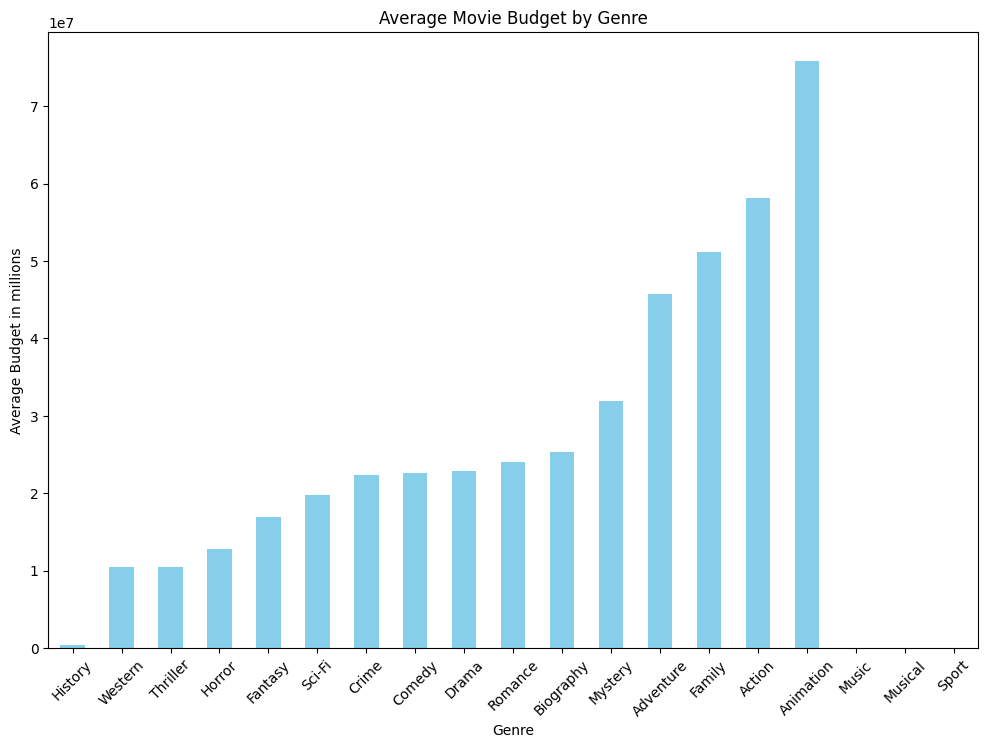

In [595]:
average_budget = df.groupby('genre')['budget'].mean()

# Plotting
plt.figure(figsize=(12, 8))
average_budget.sort_values().plot(kind='bar', color='skyblue')
plt.title('Average Movie Budget by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Budget in millions')
plt.xticks(rotation=45)
plt.show()

### Average gross by genre

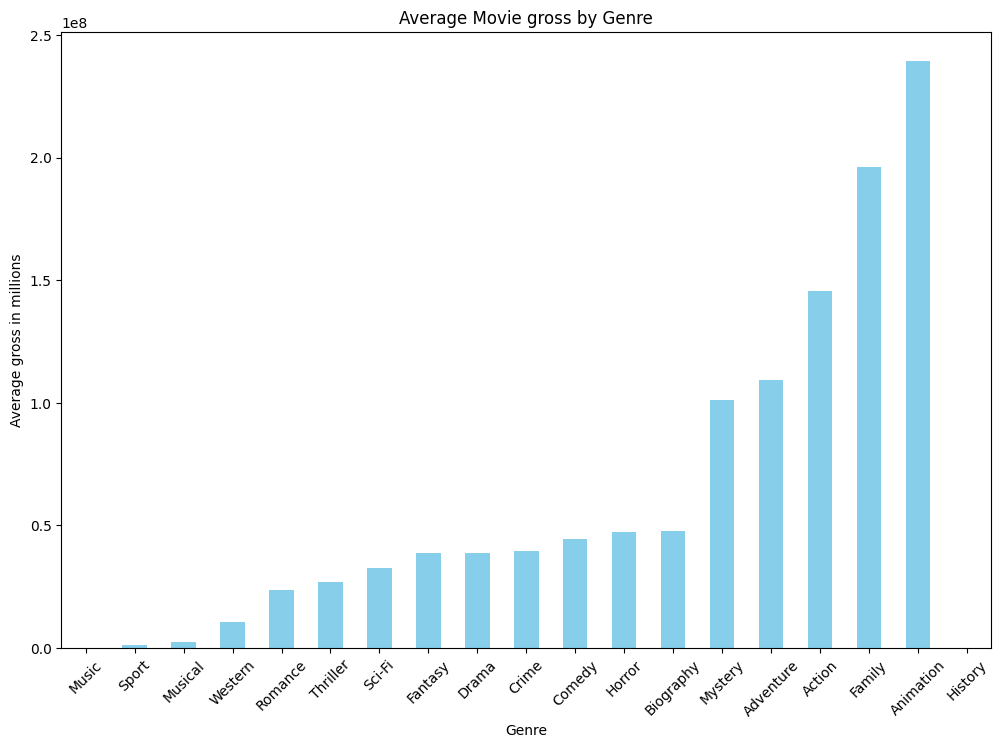

In [596]:
average_budget = df.groupby('genre')['gross'].mean()

# Plotting
plt.figure(figsize=(12, 8))
average_budget.sort_values().plot(kind='bar', color='skyblue')
plt.title('Average Movie gross by Genre')
plt.xlabel('Genre')
plt.ylabel('Average gross in millions')
plt.xticks(rotation=45)
plt.show()

### Data distribution before filling missing values



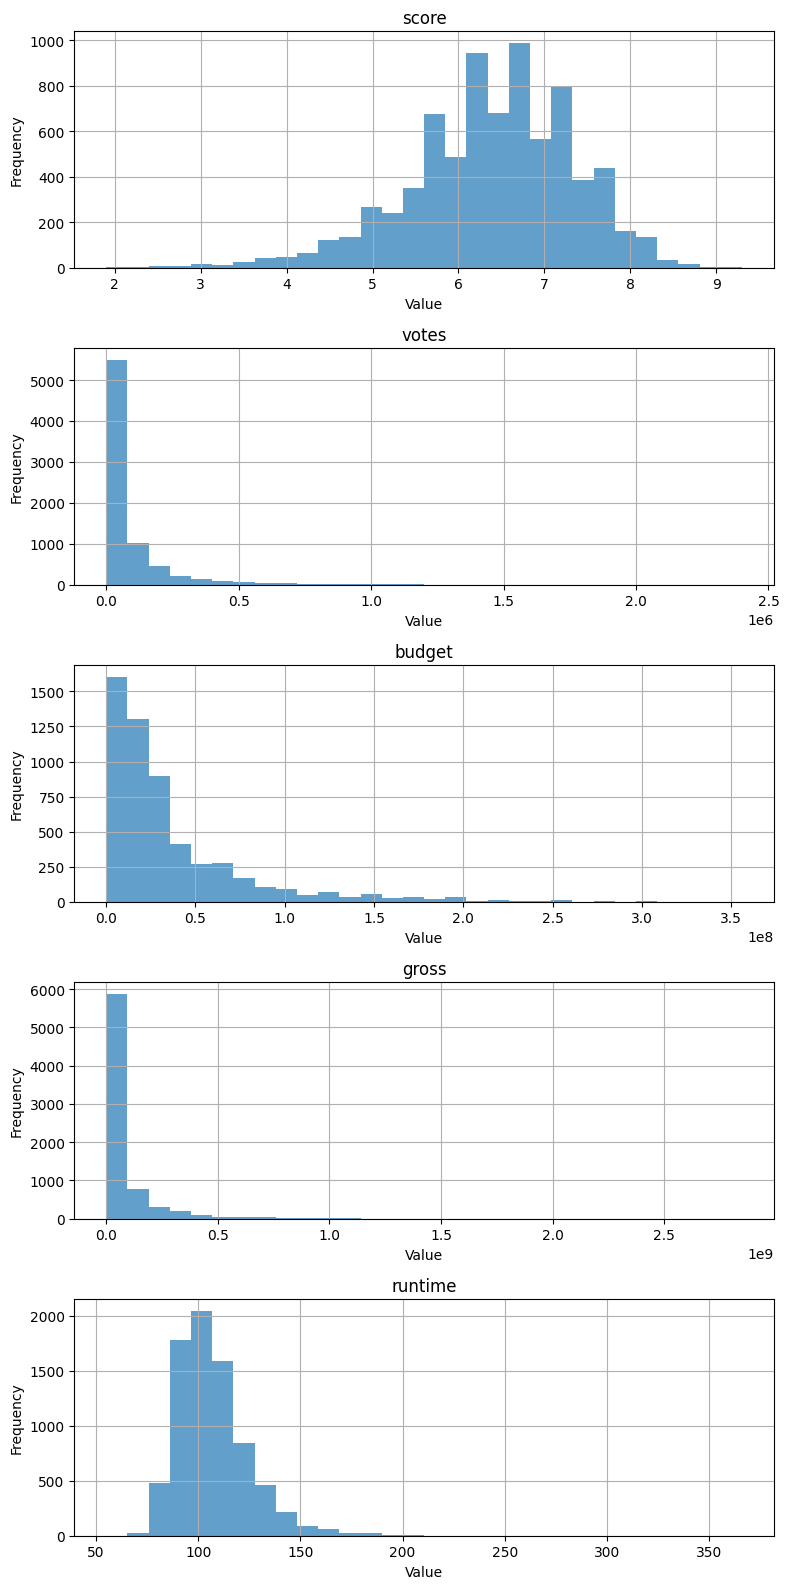

In [597]:
# Select numeric columns for distribution analysis
numeric_columns = ['score', 'votes', 'budget', 'gross', 'runtime']

# Plot histograms for numeric columns to understand their distributions
fig, axes = plt.subplots(nrows=len(numeric_columns), figsize=(8, 16))
for i, col in enumerate(numeric_columns):
    df[col].hist(ax=axes[i], bins=30, alpha=0.7)
    axes[i].set_title(col)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


The histograms of the numeric columns reveal the following about their distributions:

Score: The distribution is slightly left-skewed but fairly normal. Using the median to fill missing values might be reasonable here.

Votes: This distribution is heavily right-skewed with a long tail, indicating the presence of outliers. The median would be a better choice than the mean for filling missing values here due to the skew.

Budget and Gross: Both are heavily right-skewed. The presence of a large number of films with lower values and a few films with very high values suggests that the median is again a more robust choice than the mean, which could be significantly influenced by the high-value outliers.

Runtime: This shows a fairly normal distribution with a slight skew. The median should work well for filling missing values.

For the categorical columns like rating, writer, star, country, and company, using the mode (most frequent value) would be more appropriate than the median.

In [598]:
median_budget_by_genre = df.groupby('genre')['budget'].median()
median_gross_by_genre = df.groupby('genre')['gross'].median()

In [599]:
def fill_missing_with_median(row, column, median_series):
    if pd.isna(row[column]):
        return median_series[row['genre']]
    return row[column]

In [600]:
# Apply median and mode values using recommended methods
df.fillna({
    'score': df['score'].median(),
    'votes': df['votes'].median(),
    # 'budget': df['budget'].median(),
    'budget': df.apply(lambda row: fill_missing_with_median(row, 'budget', median_budget_by_genre), axis=1),
    'gross': df.apply(lambda row: fill_missing_with_median(row, 'gross', median_gross_by_genre), axis=1),
    'runtime': df['runtime'].median(),
    'rating': df['rating'].mode()[0],
    'writer': df['writer'].mode()[0],
    'star': df['star'].mode()[0],
    'country': df['country'].mode()[0],
    'release_country': df['release_country'].mode()[0],
    'release_date': df['release_date'].mode()[0],
    'company': df['company'].mode()[0]
}, inplace=True)

# Verify that all missing values have been filled
df.isnull().sum()


name               0
rating             0
genre              0
year               0
score              0
votes              0
director           0
writer             0
star               0
country            0
budget             4
gross              1
company            0
runtime            0
release_date       0
release_country    0
dtype: int64

In [601]:
df.shape

(7668, 16)

After filling in the data with with median, mode and sorted gross and budget by genre we can see that the data distribution is the same as it was before, except the budget. The budget peak slightly moved to the right

In [602]:
median_budget_by_genre = df.groupby('genre')['budget'].median()

median_budget_by_genre


genre
Action       40000000.0
Adventure    25000000.0
Animation    70000000.0
Biography    20000000.0
Comedy       17000000.0
Crime        15000000.0
Drama        15000000.0
Family       17000000.0
Fantasy       9000000.0
History        323562.0
Horror        8750000.0
Music               NaN
Musical             NaN
Mystery      24000000.0
Romance      22000000.0
Sci-Fi       13000000.0
Sport               NaN
Thriller      8000000.0
Western      10500000.0
Name: budget, dtype: float64

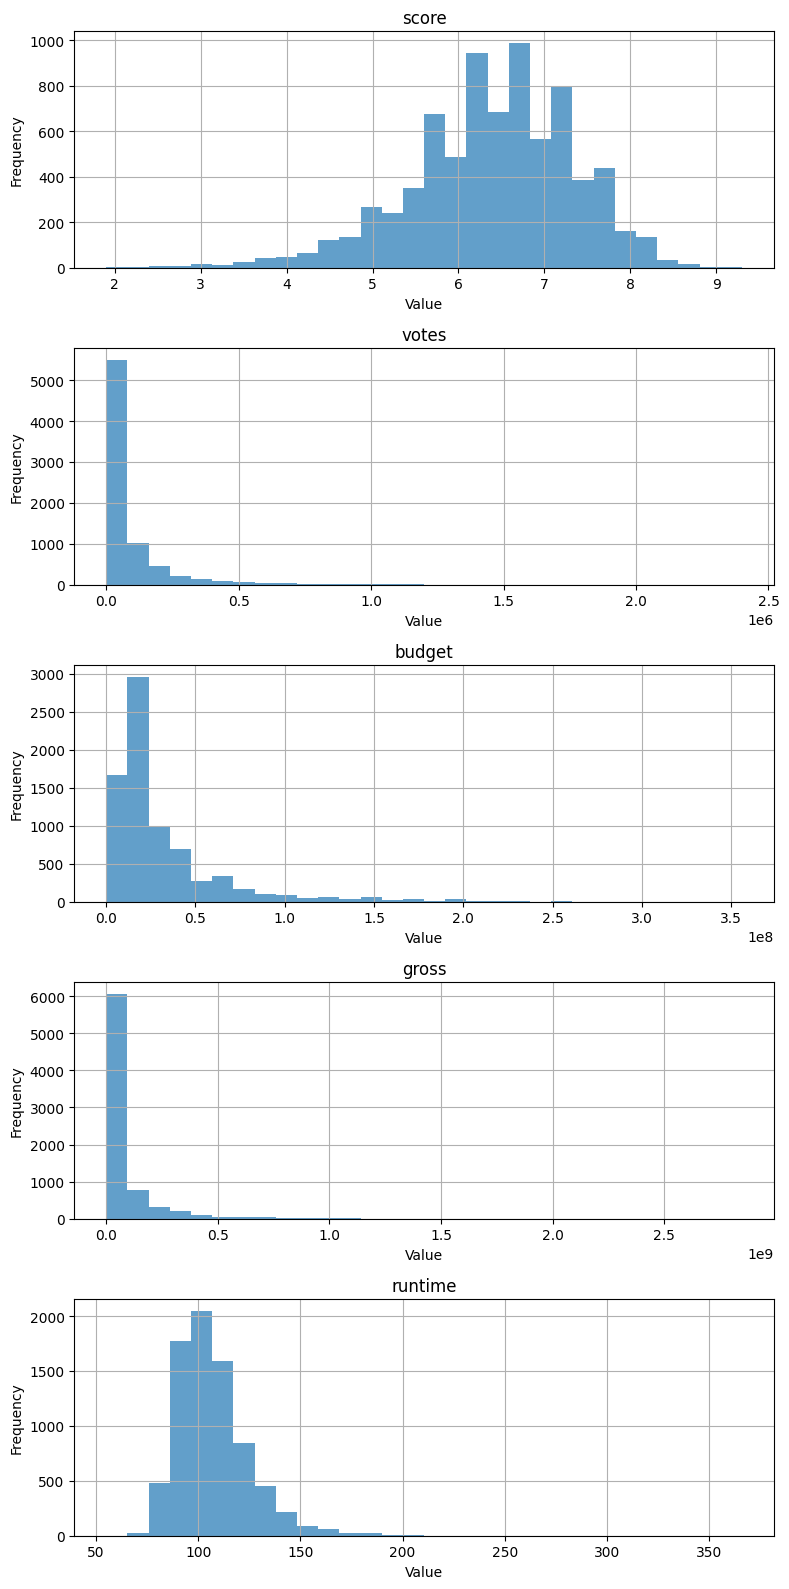

In [603]:
import matplotlib.pyplot as plt

# Select numeric columns for distribution analysis
numeric_columns = ['score', 'votes', 'budget', 'gross', 'runtime']

# Plot histograms for numeric columns to understand their distributions
fig, axes = plt.subplots(nrows=len(numeric_columns), figsize=(8, 16))
for i, col in enumerate(numeric_columns):
    df[col].hist(ax=axes[i], bins=30, alpha=0.7)
    axes[i].set_title(col)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [604]:
top_voted = df.sort_values(['score'], ascending = False)
top_voted


,name,rating,genre,year,score,votes,director,writer,star,country,budget,gross,company,runtime,release_date,release_country
2443,The Shawshank Redemption,R,Drama,1994,9.3,2400000.0,Frank Darabont,Stephen King,Tim Robbins,United States,25000000.0,2.881729e+07,Castle Rock Entertainment,142.0,October 14,United States
5243,The Dark Knight,PG-13,Action,2008,9.0,2400000.0,Christopher Nolan,Jonathan Nolan,Christian Bale,United States,185000000.0,1.005974e+09,Warner Bros.,152.0,July 18,United States
2444,Pulp Fiction,R,Crime,1994,8.9,1900000.0,Quentin Tarantino,Quentin Tarantino,John Travolta,United States,8000000.0,2.139288e+08,Miramax,154.0,October 14,United States
4245,The Lord of the Rings: The Return of the King,PG-13,Action,2003,8.9,1700000.0,Peter Jackson,J.R.R. Tolkien,Elijah Wood,New Zealand,94000000.0,1.146031e+09,New Line Cinema,201.0,December 17,United States
2247,Schindler's List,R,Biography,1993,8.9,1200000.0,Steven Spielberg,Thomas Keneally,Liam Neeson,United States,22000000.0,3.221612e+08,Universal Pictures,195.0,February 04,United States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4412,From Justin to Kelly,PG,Comedy,2003,2.1,25000.0,Robert Iscove,Kim Fuller,Kelly Clarkson,United States,12000000.0,4.928883e+06,19 Entertainment,81.0,June 20,United States
4342,House of the Dead,R,Action,2003,2.1,36000.0,Uwe Boll,Mark A. Altman,Jonathan Cherry,Germany,12000000.0,1.381818e+07,Boll Kino Beteiligungs GmbH & Co. KG,90.0,October 10,United States
5306,Disaster Movie,PG-13,Comedy,2008,1.9,88000.0,Jason Friedberg,Jason Friedberg,Carmen Electra,United States,20000000.0,3.481682e+07,Lionsgate,87.0,August 29,United States
5354,The Hottie & the Nottie,PG-13,Comedy,2008,1.9,36000.0,Tom Putnam,Heidi Ferrer,Paris Hilton,United States,17000000.0,1.596232e+06,Purple Pictures,91.0,February 21,Russia


# EDA

## Country


In [605]:
countries = df['country'].value_counts()
countries

country
United States                     5478
United Kingdom                     816
France                             279
Canada                             190
Germany                            117
Australia                           92
Japan                               81
India                               62
Italy                               61
Spain                               47
Hong Kong                           45
Ireland                             43
China                               40
South Korea                         35
Denmark                             32
Sweden                              25
New Zealand                         25
Mexico                              22
Norway                              12
West Germany                        12
Netherlands                         12
Iran                                10
Switzerland                         10
Russia                               8
Belgium                              8
Argentina        

To simplify further prediction I created 3 country categories: USA (as most of the movies are made in USA), UK (second country to produce most movies) and other countries

In [606]:
df['country'] = df['country'].apply(lambda x: 'USA' if x == 'United States' else ('UK' if x == 'United Kingdom' else 'Others'))

# Check the first few rows to confirm the changes
countries = df['country'].value_counts()
countries


country
USA       5478
Others    1374
UK         816
Name: count, dtype: int64

## Budget

There is no strong relationship between budget and IMDb rating. While there is a wide distribution of ratings across all budget levels, I would say that rating rises with a budget, because  it has a positive relationship

The scatterplot suggests a potential nonlinear relationship, where both low and very high budgets do not necessarily correlate with higher IMDb ratings. This could mean exploring models that can handle nonlinearity effectively, such as decision trees, random forests, or support vector machine, rather than relying solely on linear models like linear regression.

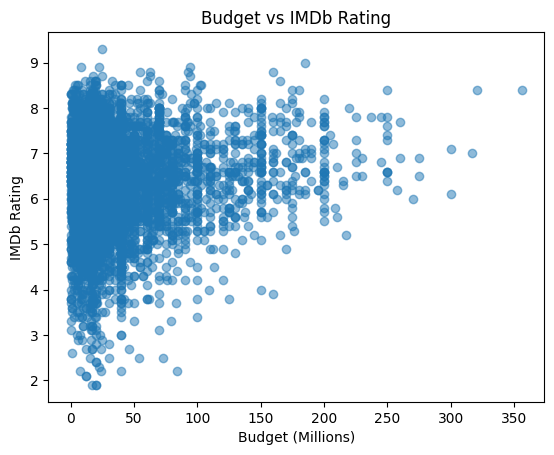

In [607]:
#Calculate budeget in millions
budget_in_millions = df['budget'] / 1e6
rating = df['score']

# Create a scatter plot
plt.scatter(budget_in_millions, rating, alpha=0.5)
plt.title('Budget vs IMDb Rating')
plt.xlabel('Budget (Millions)')
plt.ylabel('IMDb Rating')

# Show the plot
plt.show()


## Duration of the movie

This histogram indicates that most movies have a duration of around 100 to 150 minutes, which is typical for feature-length films. Very few movies are shorter than 50 minutes or longer than 200 minutes

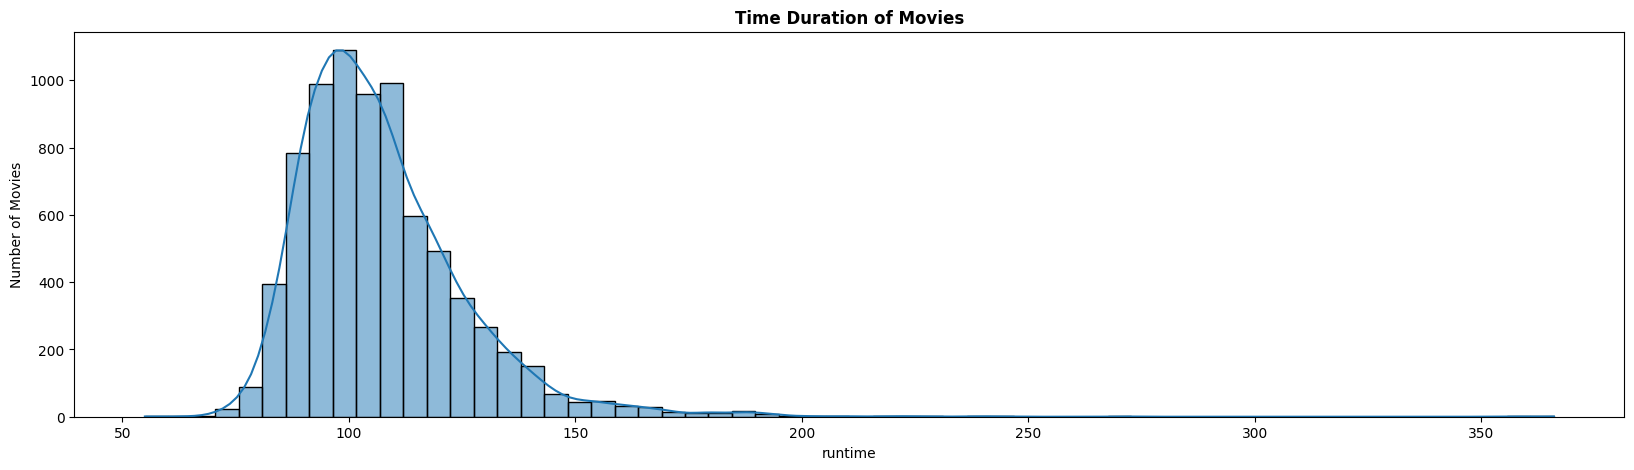

In [608]:
fig, axs = plt.subplots(figsize=(20, 5))
g = sns.histplot(df['runtime'], kde=True, bins=60)  
g.set_title("Time Duration of Movies", weight="bold")
plt.ylabel('Number of Movies')  

plt.show()

The chart does not show a clear correlation between runtime and IMDb rating; however, there's a visual indication that very few movies with extremely short or long runtimes have high IMDb ratings. The majority of movies with higher ratings (above 7) seem to have a runtime clustered around 100 to 200 minutes

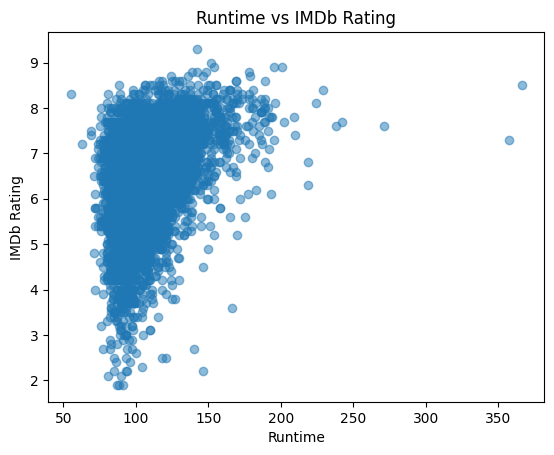

In [609]:
runtime = df['runtime'].tolist()
rating = df['score'].tolist()
plt.scatter(runtime,rating, alpha=0.5)
plt.title('Runtime vs IMDb Rating')
plt.xlabel('Runtime')
plt.ylabel('IMDb Rating')
plt.show()

### Categorizing runtime of a movie to short, average and long

I categorized runtimes into bins (short, average, long) to see if these categories are better predictors of IMDb scores than the numeric value. Sometimes, models perform better with categorical data especially when there's non-linear relationships.

In [610]:
# Define bins and labels
bins = [0, 90, 120, float('inf')] 
labels = ['Short', 'Average', 'Long']

# Create a new column for the categorized runtime
df['runtime_category'] = pd.cut(df['runtime'], bins=bins, labels=labels)



In [611]:
# Check the counts of each category
print(df['runtime_category'].value_counts())
print(df.head())


runtime_category
Average    5133
Long       1420
Short      1115
Name: count, dtype: int64
                                             name rating      genre  year  \
0                                     The Shining      R      Drama  1980   
1                                 The Blue Lagoon      R  Adventure  1980   
2  Star Wars: Episode V - The Empire Strikes Back     PG     Action  1980   
3                                       Airplane!     PG     Comedy  1980   
4                                      Caddyshack      R     Comedy  1980   

   score      votes         director                   writer            star  \
0    8.4   927000.0  Stanley Kubrick             Stephen King  Jack Nicholson   
1    5.8    65000.0   Randal Kleiser  Henry De Vere Stacpoole  Brooke Shields   
2    8.7  1200000.0   Irvin Kershner           Leigh Brackett     Mark Hamill   
3    7.7   221000.0     Jim Abrahams             Jim Abrahams     Robert Hays   
4    7.3   108000.0     Harold Ramis     

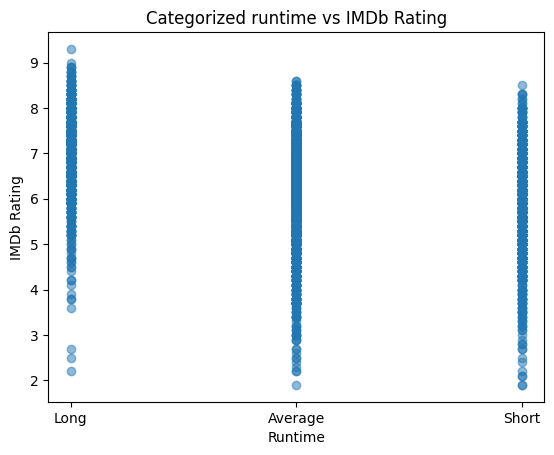

In [612]:
runtime = df['runtime_category'].tolist()
rating = df['score'].tolist()
plt.scatter(runtime,rating, alpha=0.5)
plt.title('Categorized runtime vs IMDb Rating')
plt.xlabel('Runtime')
plt.ylabel('IMDb Rating')
plt.show()

## Release year

The ratings are distributed across the full range of possible scores (from 1 to 10) for all release years, which suggests that the release date is not a strong predictor of IMDb rating.

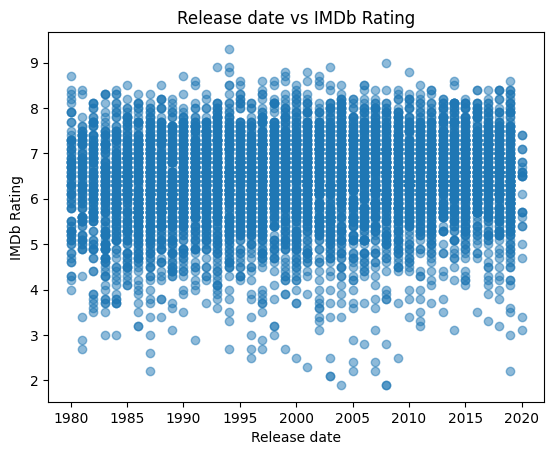

In [613]:
date = df['year'].tolist()
rating = df['score'].tolist()
plt.scatter(date, rating, alpha=0.5)
plt.title('Release date vs IMDb Rating')
plt.xlabel('Release date')
plt.ylabel('IMDb Rating')
plt.show()

## Companies

Top 10 companies with most released movies

In [614]:
top_companies = df['company'].value_counts().head(10)
top_companies

company
Universal Pictures           394
Warner Bros.                 334
Columbia Pictures            332
Paramount Pictures           320
Twentieth Century Fox        240
New Line Cinema              174
Touchstone Pictures          132
Metro-Goldwyn-Mayer (MGM)    125
Walt Disney Pictures         123
TriStar Pictures              94
Name: count, dtype: int64

The number of movies produced by top companies ranges from under 100 to just above 350.

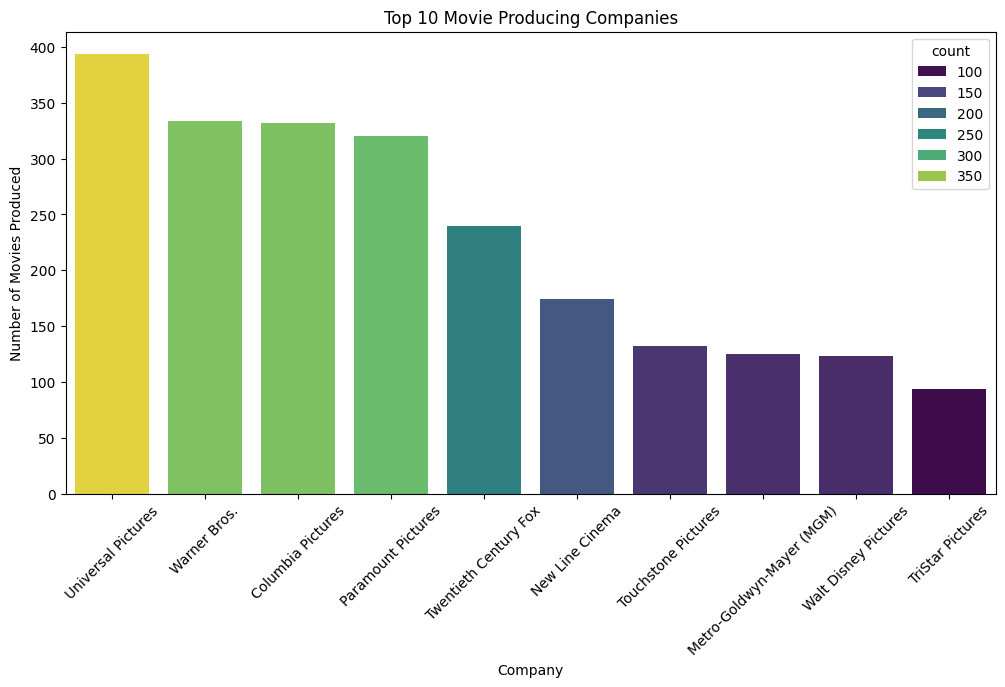

In [615]:
    # Create a bar plot for the top 10 companies
plt.figure(figsize=(12, 6))
sns.barplot(x=top_companies.index, y=top_companies.values, palette='viridis', hue=top_companies)
plt.xticks(rotation=45)
plt.title('Top 10 Movie Producing Companies')
plt.xlabel('Company')
plt.ylabel('Number of Movies Produced')
plt.show()

The lengths of the bars suggest that all companies have mean scores between approximately 5.5 and 6.5, indicating relatively high average ratings for their films on IMDb.

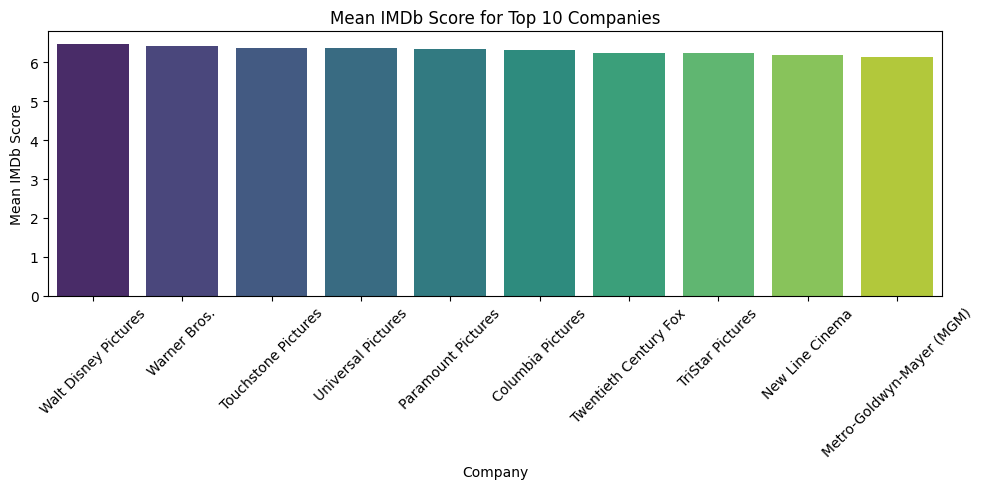

In [616]:
# Get the top 10 companies by number of movies produced
top_companies = df['company'].value_counts().nlargest(10).index

# Filter the DataFrame to only include the top 10 companies
df_top_companies = df[df['company'].isin(top_companies)]

# Group by 'company' and calculate the mean score for each company
score_via_top_company = df_top_companies.groupby('company')['score'].mean().sort_values(ascending=False)

# Create a DataFrame for the top 10 companies and their mean scores
score_via_top_company_df = pd.DataFrame(score_via_top_company).reset_index()

# Plot a bar chart
plt.figure(figsize=(10, 5))
sns.barplot(x='company', y='score', data=score_via_top_company_df, palette='viridis', hue='company')
plt.title('Mean IMDb Score for Top 10 Companies')
plt.xlabel('Company')
plt.ylabel('Mean IMDb Score')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the layout to make room for the x-axis labels
plt.show()


Metro-Goldwyn-Mayer has a high mean IMDb score as seen in the first chart but shows a relatively lower number of movies produced in the second chart.Universal Pictures, which appears to have the highest number of movies produced in the second chart, does not have the highest mean IMDb score in the first chart.

### Creating bins for company size 

Different patterns or trends might be more easily detectable when the data is divided into these smaller, more similar groups. I will check it later in a correlation matrix

In [617]:
# Count the number of movies produced by each company
company_movie_counts = df['company'].value_counts()
# Display the distribution of the counts to decide on tier thresholds
company_movie_counts.describe()

count    2385.000000
mean        3.215094
std        16.803402
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       394.000000
Name: count, dtype: float64

In [618]:
# Define function to categorize company size
def categorize_company_size(n_movies):
    if n_movies <= 2:
        return 'Small'
    elif n_movies <= 20:
        return 'Medium'
    else:
        return 'Large'

# Map the movie counts to a new column 'company_size'
df['company_size'] = df['company'].map(company_movie_counts).apply(categorize_company_size)

# Display the updated DataFrame to verify the new column
df[['name', 'company', 'company_size']].head()


,name,company,company_size
0,The Shining,Warner Bros.,Large
1,The Blue Lagoon,Columbia Pictures,Large
2,Star Wars: Episode V - The Empire Strikes Back,Lucasfilm,Medium
3,Airplane!,Paramount Pictures,Large
4,Caddyshack,Orion Pictures,Large


## Directors

 The director with the highest mean IMDb score does not have the most movies produced, nor does the director with the most movies produced have the highest mean IMDb score. This suggests there is no strong positive or negative correlation between the number of movies a director has produced and the mean IMDb score of those movies. 

In [619]:
director_scores = df.groupby('director')['score'].mean()

# Count the number of movies for each director
director_movie_counts = df.groupby('director').size()

# Filter out directors with a very low number of movies to reduce skewing
# For example, only consider directors with more than 5 movies
min_movies = 5
filtered_directors = director_movie_counts[director_movie_counts > min_movies].index

# Apply the filter to the director_scores
filtered_director_scores = director_scores.loc[filtered_directors].sort_values(ascending=False)

print(filtered_director_scores)

director
Christopher Nolan     8.163636
Hayao Miyazaki        8.142857
Quentin Tarantino     8.100000
James Cameron         7.871429
Giuseppe Tornatore    7.814286
                        ...   
Sidney J. Furie       5.157143
Raja Gosnell          5.111111
Bob Clark             5.030000
Brian Levant          5.025000
Aaron Norris          4.983333
Name: score, Length: 318, dtype: float64


### Creating a column with the average IMDB score for a director and a movie count

In [620]:
# Calculate the average IMDb score and movie count for each director
director_stats = df.groupby('director').agg(
    director_average_rating=('score', 'mean'),
    director_movie_count=('director', 'count')
)

# Merge the calculated stats back into the original dataframe
df = df.merge(director_stats, on='director', how='left')

# Display the first few rows to confirm the new columns are added correctly
df.head()


,name,rating,genre,year,score,votes,director,writer,star,country,budget,gross,company,runtime,release_date,release_country,runtime_category,company_size,director_average_rating,director_movie_count
0,The Shining,R,Drama,1980,8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,UK,19000000.0,46998772.0,Warner Bros.,146.0,June 13,United States,Long,Large,8.033333,3
1,The Blue Lagoon,R,Adventure,1980,5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,USA,4500000.0,58853106.0,Columbia Pictures,104.0,July 02,United States,Average,Large,5.862500,8
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,USA,18000000.0,538375067.0,Lucasfilm,124.0,June 20,United States,Long,Medium,6.900000,3
3,Airplane!,PG,Comedy,1980,7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,USA,3500000.0,83453539.0,Paramount Pictures,88.0,July 02,United States,Short,Large,6.637500,8
4,Caddyshack,R,Comedy,1980,7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,USA,6000000.0,39846344.0,Orion Pictures,98.0,July 25,United States,Average,Large,6.377778,9


## Actors

I grouped the original dataset by the actor's name (star) and calculated the average of their movie ratings (score). This helps in understanding the general reception of movies associated with each actor.

In [621]:
# Calculate the average score for each star
average_scores = df.groupby('star')['score'].mean().reset_index()
average_scores.rename(columns={'score': 'main_star_average_score'}, inplace=True)

# Merge this back with the original dataset
df = df.merge(average_scores, on='star', how='left')

average_scores


,star,main_star_average_score
0,'Weird Al' Yankovic,7.0000
1,50 Cent,5.4000
2,A.J. Cook,6.2000
3,Aaliyah,5.3000
4,Aamir Khan,7.9625
...,...,...
2809,Zoe Saldana,6.4000
2810,Zoey Deutch,6.0500
2811,Zooey Deschanel,7.2500
2812,Álex Angulo,7.4000


## Average rating per Genre

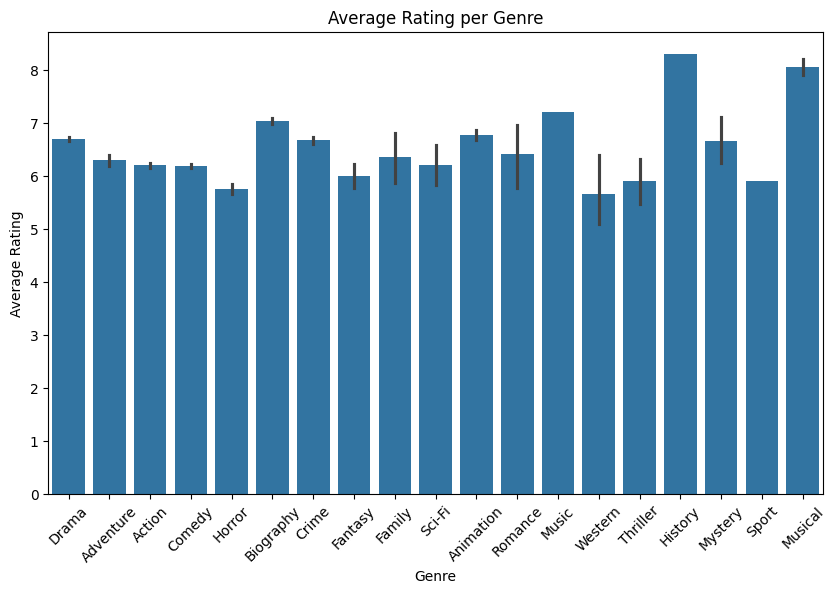

In [622]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='genre', y='score')
plt.title('Average Rating per Genre')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)  # Rotate genre labels for better readability
plt.show()

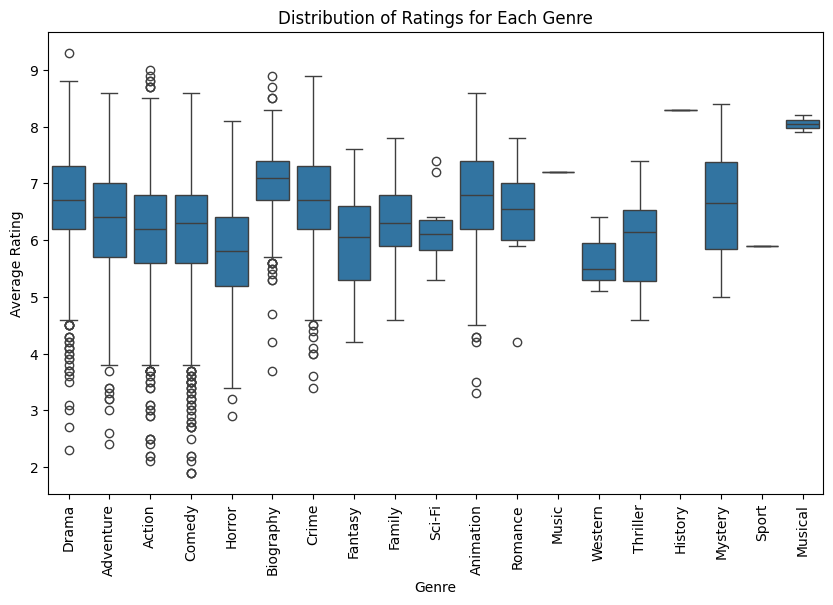

In [623]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='genre', y='score', )
plt.title('Distribution of Ratings for Each Genre')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.xticks(rotation=90)  # Rotate genre labels for better readability if there are many genres
plt.show()

### Checking why there are so many outliers

In [624]:
df['genre'] = df['genre'].str.split('|')
df = df.explode('genre').reset_index(drop=True)

In [625]:
unique_genres = df['genre'].unique()
num_genres = len(unique_genres)
cols = 5 
rows = (num_genres + cols - 1) // cols


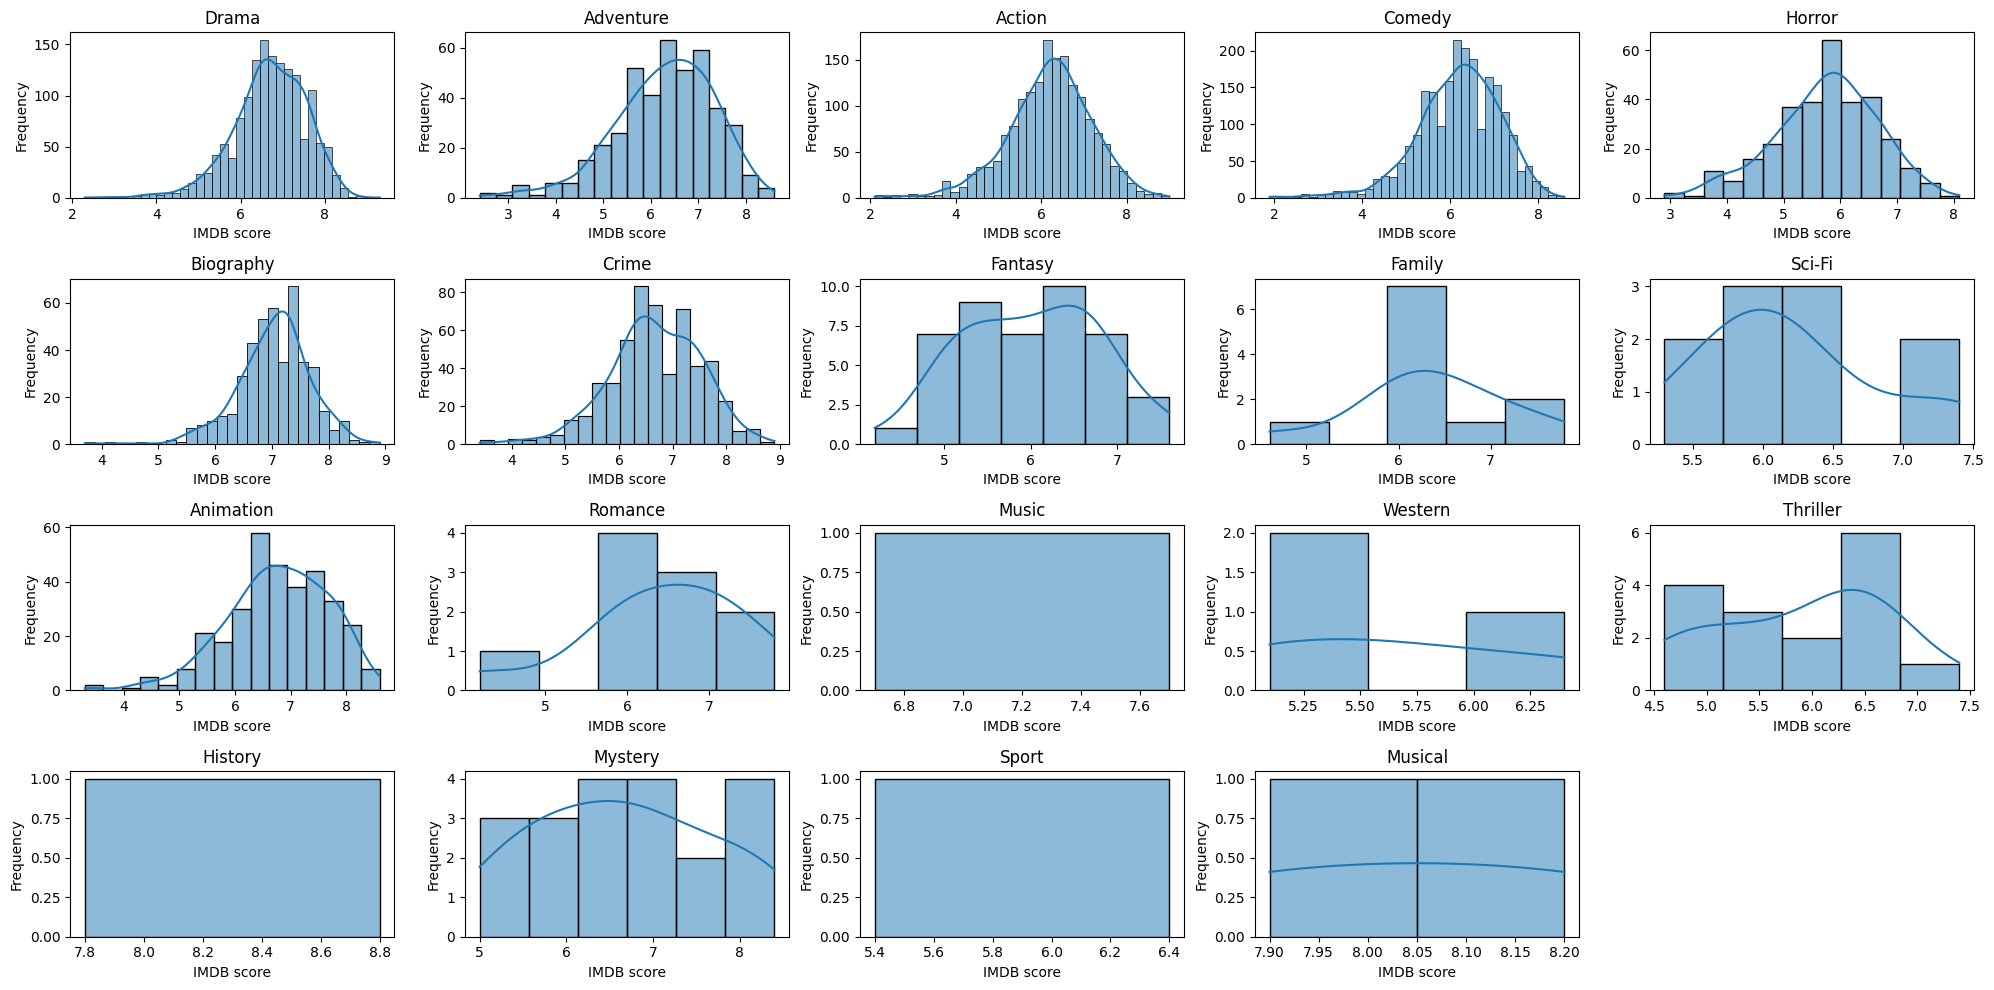

In [626]:
plt.figure(figsize=(20, 10)) 
for i, genre in enumerate(unique_genres):
    ax = plt.subplot(rows, cols, i + 1) 
    sns.histplot(df[df['genre'] == genre]['score'], kde=True, ax=ax)
    ax.set_title(genre)
    ax.set_xlabel('IMDB score')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Most genres show some outliers, especially on the lower end of the rating scale. This indicates that even within popular genres, some movies perform significantly below the average. 

It might be useful to use scalers that are less sensitive to outliers, like RobustScaler from scikit-learn, which scales features using statistics that are robust to outliers.

## Data prepocessing

Encoding the data to create a predictive model

In [627]:
from sklearn.preprocessing import LabelEncoder

encoded_df = df.copy()

# Initialize LabelEncoder
le = LabelEncoder()

# Specified categorical columns to encode
categorical_columns = ['name', 'rating', 'genre', 'director', 'writer', 'star', 'country', 'company', 'runtime_category', 'release_date', 'release_country', 'company_size']

# Apply label encoding to each categorical column in the DataFrame
for column in categorical_columns:
    encoded_df[column] = le.fit_transform(encoded_df[column].astype(str))  # Ensuring data type compatibility

# Handle missing values for numerical columns if there are any
numerical_columns = ['budget', 'gross', 'runtime', 'score', 'votes']
encoded_df[numerical_columns] = df[numerical_columns].fillna(encoded_df[numerical_columns].mean())

# Confirm changes and check for any remaining issues
encoded_df.head(), encoded_df.isnull().sum()


(   name  rating  genre  year  score      votes  director  writer  star  \
 0  6587       6      6  1980    8.4   927000.0      2589    4014  1047   
 1  5573       6      1  1980    5.8    65000.0      2269    1632   327   
 2  5142       4      0  1980    8.7  1200000.0      1111    2567  1745   
 3   286       4      4  1980    7.7   221000.0      1301    2000  2246   
 4  1027       6      4  1980    7.3   108000.0      1054     521   410   
 
    country  ...        gross  company  runtime  release_date  release_country  \
 0        1  ...   46998772.0     2319    146.0           195               56   
 1        2  ...   58853106.0      731    104.0           153               56   
 2        2  ...  538375067.0     1540    124.0           202               56   
 3        2  ...   83453539.0     1812     88.0           153               56   
 4        2  ...   39846344.0     1777     98.0           176               56   
 
    runtime_category  company_size  director_average_r

## Correlation heatmap

According to the heatmap strong correlation between score is number of votes, runtime and gross income. Also there is somewhat correlation with budget, director and wrtier. I selected corelated features to train the model

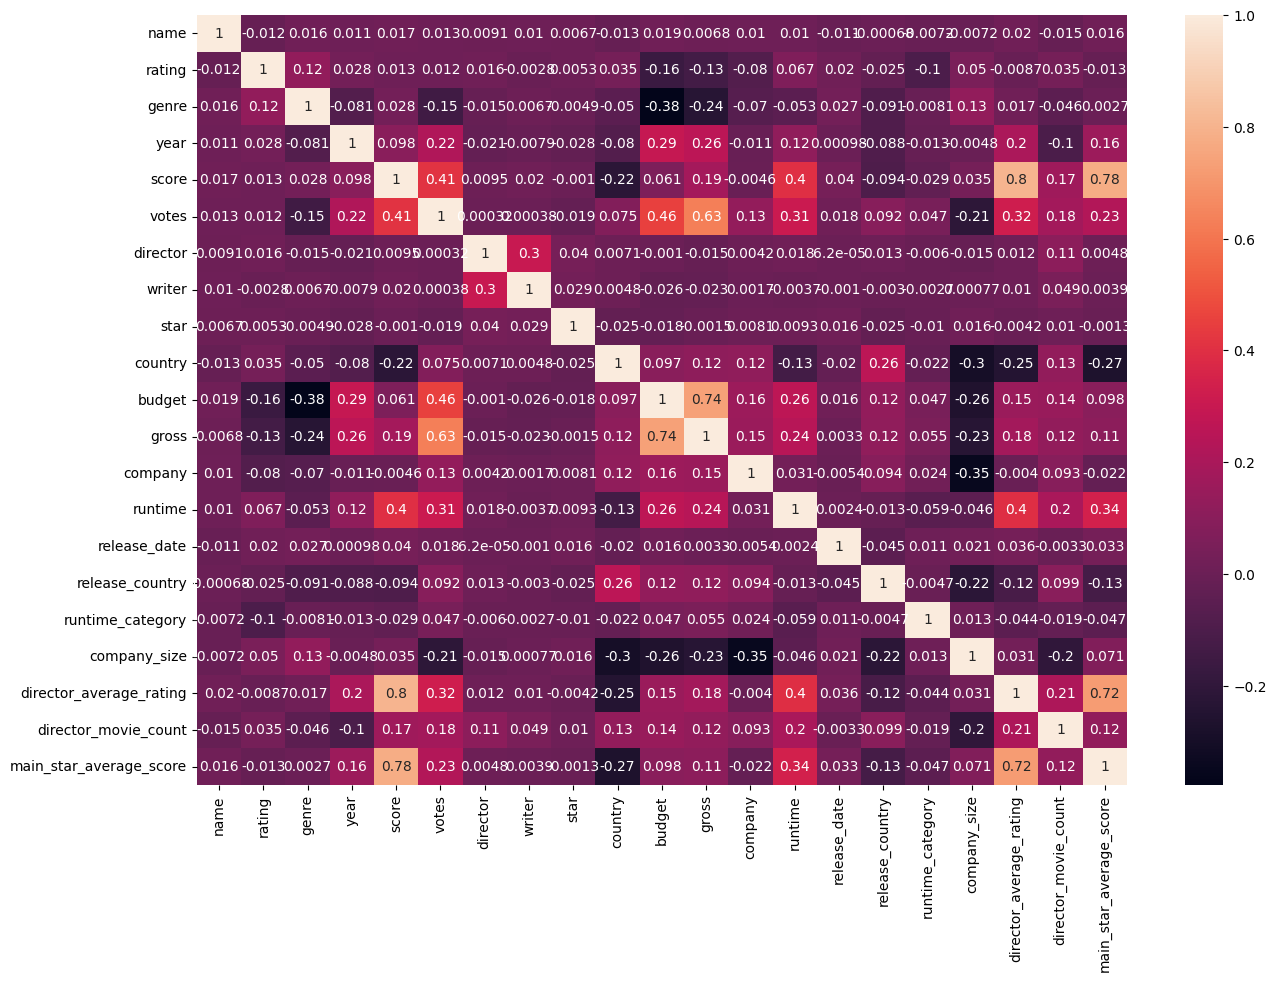

In [628]:
# Calculate correlation matrix and plot heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(encoded_df.corr(), annot=True)
plt.show()

# IMDB score prediction model training


## Iteration 0

In my iteration 0 I tried out KNN model and Linear regression and the prediction score is very low, but I will keep improving a model in further iteration

### KNN model

In [629]:
features = ['country', 'gross', 'runtime', 'year', 'writer', 'budget', 'votes']
target = "score"

X = encoded_df[features]
y = encoded_df[target]

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn_model = KNeighborsRegressor()
knn_model.fit(X_train_scaled, y_train)

r2_score = knn_model.score(X_test_scaled, y_test)
print("R² for the KNN model:", r2_score)


There are in total 7668 observations, of which 6134 are now in the train set, and 1534 in the test set.
R² for the KNN model: 0.31358278181524


### Linear regression model

In [630]:
from sklearn.linear_model import LinearRegression

# Create a Linear Regression model
lr_model = LinearRegression()

# Fit the model to the scaled training data
lr_model.fit(X_train_scaled, y_train)

# Compute the R² score using the scaled test data
r2_score_lr = lr_model.score(X_test_scaled, y_test)
print("R² for the Linear Regression model:", r2_score_lr)





R² for the Linear Regression model: 0.31661101130119085


The scatter plot comparing actual and predicted IMDB scores shows a positive correlation, indicating that the linear regression model generally captures the trend in the data. Most data points are concentrated between actual scores of 5 to 8, suggesting that the model performs best in this range. The plot highlights areas for model improvement, such as adding more features and adjusting parameters.

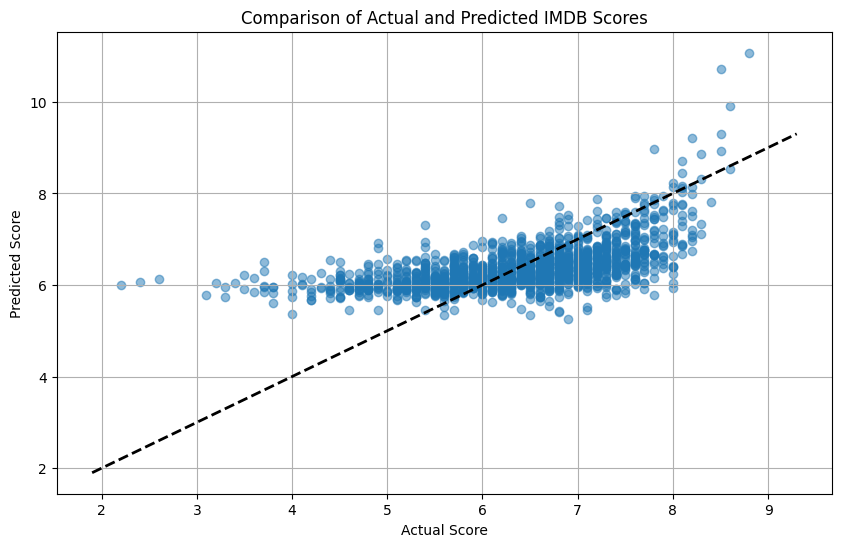

In [631]:
import matplotlib.pyplot as plt

# Predict the scores using the test data
y_pred = lr_model.predict(X_test_scaled)

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # Add a reference line
plt.title('Comparison of Actual and Predicted IMDB Scores')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.grid(True)
plt.show()


## Iteration 1

After receiving a feedback I had to delete gross income and votes features as they will be not available for the upcoming movie.

In [632]:
features = ['country', 'runtime', 'year', 'writer', 'budget']
target = "score"

X = encoded_df[features]
y = encoded_df[target]

In [633]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

There are in total 7668 observations, of which 6134 are now in the train set, and 1534 in the test set.


### Support vector machine

In my further iteration I tried out support vector machine model. This model performed relatively better, but the prediction rate after deleting most correlated features is still low. I will try creating new features to predict IMDB score 

In [634]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Create a support vector machine regressor object
svm_regressor = make_pipeline(StandardScaler(), SVR())

# Train the model using the training sets
svm_regressor.fit(X_train, y_train)

# The number of observations in each set
print(f"There are in total {len(X)} observations, of which {len(X_train)} are now in the train set, and {len(X_test)} in the test set.")


There are in total 7668 observations, of which 6134 are now in the train set, and 1534 in the test set.


In [635]:
from sklearn.metrics import r2_score
from sklearn.metrics import precision_score, recall_score, f1_score

# Predict on the test set
y_pred = svm_regressor.predict(X_test)

# Calculate the R^2 score and the mean squared error
r2 = r2_score(y_test, y_pred)

print("R² for the suppor vector machine", r2)


R² for the suppor vector machine 0.2154937900783117


## Final iteration

In my final iteration I created new features: 'main_star_average_score' and 'director_average_rating' to try improving perfomance of the model 

## Feature selection


### Selecting features and a target variable 

I am using features that correlate with the score the most:

main_star_average_score - the average IMDB score of the main actor 

director_average_rating - the average IMDB score of all the movies director has created

country - country of a movie origin

runtime - length of the movie

company - which company was producing the movie

writer - writer of a movie

genre - genre of a movie


In [636]:
features = ['country', 'runtime', 'writer', 'company', 'main_star_average_score', 'director_average_rating', 'genre']
target = "score"

X = encoded_df[features]
y = encoded_df[target]

## Creating test and train test

In [637]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

There are in total 7668 observations, of which 6134 are now in the train set, and 1534 in the test set.


## Modeling

I decided to choose Support Vector Regressor as it's specifically made for predicting values that can change smoothly from one number to another. This is different from SVM, which is more about sorting data into specific categories (like yes/no) and my project requires quantitative output (e.g., scores from 1 to 10) rather than categorical labels.

I am also using a RobustScaler because some of my features have a lot of outliers. RobustScaler adjusts your data by removing the median and scaling it according to a quantile range. Since the median and the interquartile range are less influenced by outliers than the mean and standard deviation. Data will not be skewed or distorted by outliers, which can lead to more effective and accurate predictions.

### Choosing kernel

Linear Kernel


In [638]:
from sklearn.preprocessing import RobustScaler
model_linear = make_pipeline(RobustScaler(), SVR(kernel='linear'))
model_linear.fit(X_train, y_train)


Pipeline(steps=[('robustscaler', RobustScaler()),
                ('svr', SVR(kernel='linear'))])

Polynomial Kernel

In [639]:
model_poly = make_pipeline(RobustScaler(), SVR(kernel='poly', degree=3))  # Degree is adjustable
model_poly.fit(X_train, y_train)


Pipeline(steps=[('robustscaler', RobustScaler()), ('svr', SVR(kernel='poly'))])

Radial Basis Function (RBF) Kernel

In [640]:
model_rbf = make_pipeline(RobustScaler(), SVR(kernel='rbf'))
model_rbf.fit(X_train, y_train)

Pipeline(steps=[('robustscaler', RobustScaler()), ('svr', SVR())])

In [641]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

# Predict with each model
y_pred_linear = model_linear.predict(X_test)
y_pred_poly = model_poly.predict(X_test)
y_pred_rbf = model_rbf.predict(X_test)

# Calculate MSE for each model
mse_linear = mean_squared_error(y_test, y_pred_linear)
mse_poly = mean_squared_error(y_test, y_pred_poly)
mse_rbf = mean_squared_error(y_test, y_pred_rbf)

# Calculate MAE for each model
mae_linear = mean_absolute_error(y_test, y_pred_linear)
mae_poly = mean_absolute_error(y_test, y_pred_poly)
mae_rbf = mean_absolute_error(y_test, y_pred_rbf)

# Calculate R² Score for each model
r2_linear = r2_score(y_test, y_pred_linear)
r2_poly = r2_score(y_test, y_pred_poly)
r2_rbf = r2_score(y_test, y_pred_rbf)


print("MSE - Linear Kernel:", mse_linear)
print("MSE - Polynomial Kernel:", mse_poly)
print("MSE - RBF Kernel:", mse_rbf)

print("MAE - Linear Kernel:", mae_linear)
print("MAE - Polynomial Kernel:", mae_poly)
print("MAE - RBF Kernel:", mae_rbf)

print("R2 Score - Linear Kernel:", r2_linear)
print("R2 Score - Polynomial Kernel:", r2_poly)
print("R2 Score - RBF Kernel:", r2_rbf)


MSE - Linear Kernel: 0.2404592820917062
MSE - Polynomial Kernel: 0.5403861840429358
MSE - RBF Kernel: 0.2310922259329882
MAE - Linear Kernel: 0.36957293226772087
MAE - Polynomial Kernel: 0.46053379961598695
MAE - RBF Kernel: 0.34503768340947066
R2 Score - Linear Kernel: 0.7397998160052772
R2 Score - Polynomial Kernel: 0.4152499196826478
R2 Score - RBF Kernel: 0.749935876109864


After experimenting with different kernels I found out that the best performing kernel is RBF, which I am going to choose for my final model

## Model evaluation

In [642]:
X = encoded_df[features]
y = encoded_df[target]

In [643]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

There are in total 7668 observations, of which 6134 are now in the train set, and 1534 in the test set.


In [644]:
from sklearn.preprocessing import RobustScaler

model = make_pipeline(RobustScaler(), SVR(kernel='rbf'))
model.fit(X_train, y_train)

Pipeline(steps=[('robustscaler', RobustScaler()), ('svr', SVR())])

The scatter plot comparing actual and predicted IMDB scores using the Support Vector Regression (SVR) model indicates a strong positive correlation, with most data points clustering close to the reference line. This shows that the SVR model is effective at capturing the relationship between the features and the scores, particularly in the mid-range (4 to 8). However, the model under-predicts at the lower score range,

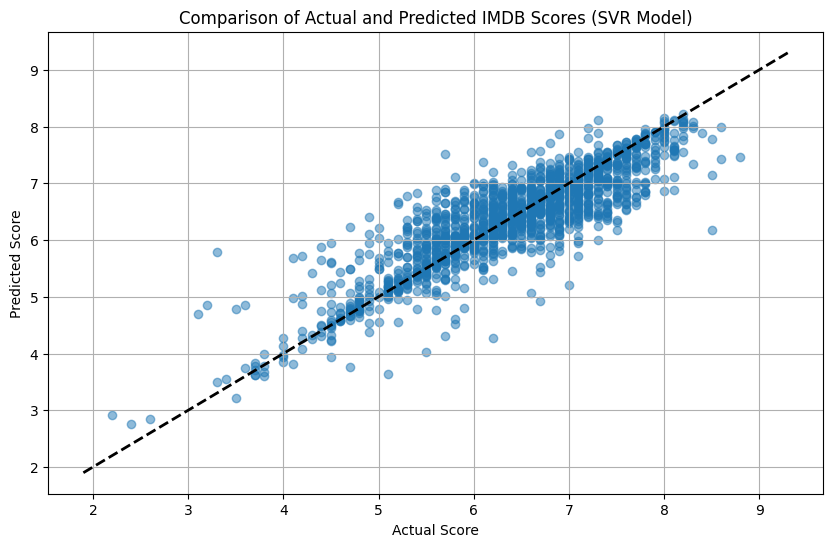

In [645]:
import matplotlib.pyplot as plt

# Predict the scores using the test data
y_pred_svr = model.predict(X_test)

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_svr, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # Add a reference line
plt.title('Comparison of Actual and Predicted IMDB Scores (SVR Model)')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.grid(True)
plt.show()


### Mean Squared Error and R2 score

Squaring the errors gives greater weight to larger errors compared to smaller ones. This characteristic is crucial when predicting IMDb scores because large deviations from actual scores can be more problematic. For example, mispredicting a movie's score by a large margin might mislead marketing strategies or audience expectations significantly more than a small misprediction. By penalizing larger errors more severely, MSE pushes the model to avoid making big mistakes, which is particularly valuable in scenarios where accuracy is critical.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

Mean Squared Error: 0.2310922259329882
R2 Score: 0.749935876109864


### Cross-Validated MSE

I am choosing "neg_mean_squared_error" as it adjusts all errors to a common scale, as squaring the errors eliminates any negative signs. This is crucial because it ensures that underestimations and overestimations are treated equally, making the evaluation metric fair and balanced.



In [646]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-Validated MSE: {-scores.mean()}")

Cross-Validated MSE: 0.258117010946439


The close values of MSE (0.23 and 0.25) from both the single split and cross-validation suggest that the model fits the data well without major overfitting issues.

### Mean absolute error

Checking the Mean Absolute Error (MAE) alongside Mean Squared Error (MSE) can provide a more nuanced understanding of model’s performance. MAE gives a straightforward, linear measure of prediction errors, treating all errors with equal importance regardless of their size. This allows for a clearer and more direct interpretation of how accurately a model predicts outcomes on average

The relatively low value of mean absolute error suggests that the model's predictions are reasonably close to the true values.

In [647]:
from sklearn.metrics import mean_absolute_error
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 0.34503768340947066


## Reflection

 DAIA: Data analysis part helped me to understand data more clearly, find missing values and clean a dataset. While emplementing feedbacks I got from DAIA teacher Roopali G. I learned a lot more about the dataset and how to structure notebook more clearly, furthermore it helped me explore dataset more in depth and create necessary features that had a positive impact on my model's perfomance. There would be a possibility to enrich my dataset with more information such as: adding more actors and other genres of the movie.
 
 Machine learning: The predicted scores are reasonably close to the actual IMDB scores. Notably, the prediction for "Poseidon" was significantly off, suggesting areas for improvement. The accuracy of the model indicates that it captures key patterns in the data, but there is potential to enhance performance through deeper analysis of feature impacts.

I created a new train set so I could add a movie name to the table

In [649]:
import pandas as np
import pandas as pd

movie_names = df['name'] 

# Split the data, retaining the movie names for the test set
X_train, X_test, y_train, y_test, names_train, names_test = train_test_split(X, y, movie_names, test_size=0.2, random_state=1)

# Predict IMDB scores with the trained model
y_pred = model.predict(X_test)

# Create a DataFrame to compare actual and predicted scores
comparison_df = pd.DataFrame({
    'Movie Name': names_test,
    'Actual IMDB Score': y_test,
    'Predicted IMDB Score': y_pred
})

print(comparison_df.head())


              Movie Name  Actual IMDB Score  Predicted IMDB Score
2402   A Home of Our Own                7.1              6.894836
1172           The Curse                5.1              5.620253
442   Heart Like a Wheel                6.7              6.199541
4928            Poseidon                5.7              6.653353
307              Jinxed!                4.7              4.666134
